[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Weeds Identification-AutoML-1

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Cotton-100619-Healthy-zz-V1-20210225102300** and **Velvet leaf-220519-Weed-zz-V1-20210225104123** datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_autosklearn.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

# Background
In this notebook, we are going to cover a technique called **Automated Machine Learning (AutoML)**. These systems have arisen in the past years to allow computers to automatically find the most suitable machine learning (ML) pipeline matching a specific task and dataset. AutoML systems could provide insights to ML engineers resulting in better models deployed in a shorter period of time. AutoML systems are meta-level ML algorithms, which use different components as building blocks for finding the optimal ML pipeline structures **(Feurer et al., 2015; Kotthoff et al., 2017)**. These systems automatically evaluate multiple pipeline configurations, trying to improve the global performance iteratively. Several open-source technologies have arisen to raise awareness of the strengths and limitations of the AutoML systems; for example, AutoKeras, AutoSklearn, Auto-WEKA, H2O AutoML, TPOT, autoxgboost, and OBOE. Additionally, different AutoML cloud-solutions are now offered by IT firms such as Google Cloud AutoML Vision, Microsoft Azure Machine Learning, and Apple’s Create ML. They offer user-friendly interfaces and require little expertise in machine learning to train models. In this notebook, we will be using **AutoSklearn**.

In the **agricultural domain**, some recent research studies have made use of the AutoML technique in the past few years, using it to process time series as well as proximal and satellite images. In **Hayashi et al., (2019)**, the authors tested whether AutoML was a useful tool for the identification of pest insect species by using three aphid species. They constructed models that were trained by photographs of those species under various conditions in Google Cloud AutoML Vision and compared their accuracies of identification. Since the rates of correct identification were over 96% when the models were trained with 400 images per class, they considered AutoML to be useful for pest species identification. In **Montellano (2019)**, the author used AutoML through the same platform to classify different types of butterflies, image fruits, and larval host plants. Their average accuracy was around 97.1%. In **Hsieh et al., (2019)**, AutoML was implemented along with neural network algorithms to classify whether the conditions of rice blast disease were exacerbated or relieved by using five years of climatic data. Although the experiments showed 72% accuracy on average, the model obtained an accuracy of 89% in the exacerbation case. Hence, the effectiveness of the proposed classification model, which combined multiple machine learning models, was confirmed. Finally, an AutoML approach has been applied in **Kiala et al., (2020)**, in an attempt to map the Parthenium weed. The authors constructed models by using AutoML technology and 16 other classifiers that were trained by satellite pictures of Sentinel-2 and Landsat 8. AutoML model achieved a higher overall classification accuracy of 88.15% using Sentinel-2 and 74% using Landsat 8, results that confirmed the significance of the AutoML in mapping Parthenium weed infestations using satellite imagery. In **Koh et al., (2020)**, authors used wheat lodging assessment with UAV images for high-throughput plant phenotyping. They compared AutoKeras in image classification and regression tasks to transfer learning techniques. Finally in **Espejo-Garcia et. al, (2021)**, the authors integrated AutoSklearn and AutoKeras for addressing the problem of weeds identifications in 2 different datasets.

In **agriculture**, since **weeds** compete with crops in the domain of space, light and nutrients, they are an important problem that can lead to a poorer harvest by farmers. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately by deep learning has arisen as an important objective.

This notebook is quite similar to:

https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/auto_ml/weeds_identification-AutoML-2.ipynb

However, we are going to use **an ensemble of ML models** for classifying crops/weeds (contrary to the single/standalone approach used in the previous one).

#### Library Imports

In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from pathlib import Path

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from autosklearn.classification import AutoSklearnClassifier

/home/paris/anaconda3/envs/eden_autosklearn/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


#### Auxiliar functions

In [3]:
def normalize_images(images):
    return images / 255.0

In [4]:
def read_data(path_list, im_size=(224, 224)):

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_LINEAR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.array(y, dtype=np.uint8)
    return X, y

In [5]:
def plot_sample(X):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])

#### Experimental Constants

In [6]:
ENSEMBLE_SIZE = 50  # Ensemble Size
MINS_TRAIN = 10  # Minutes for searching the best pipeline

#### Reading and showing pictures

In [7]:
# Path to the desired dataset.
DATASETS = [
    "Cotton-100619-Healthy-zz-V1-20210225102300",
    "Velvet leaf-220519-Weed-zz-V1-20210225104123",
]
IM_SIZE = (128, 128)  # Dimensions to resize to.
path_list = []

for i, path in enumerate(DATASETS):
    # Define paths in an OS agnostic way.
    path_list.append(
        str(
            Path(Path.cwd()).parents[0].joinpath("eden_library_datasets").joinpath(path)
        )
    )

X, y = read_data(path_list, IM_SIZE)

100%|██████████| 129/129 [00:23<00:00,  5.51it/s]


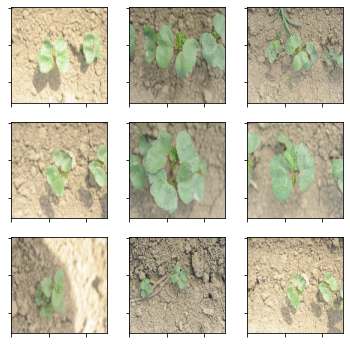

In [8]:
# Class 0
plot_sample(X[:50])

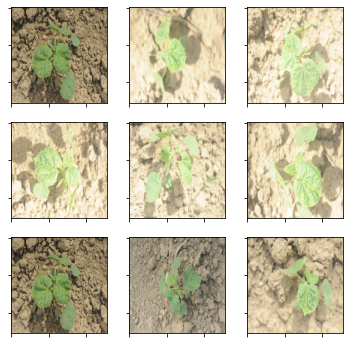

In [9]:
# Class 1
plot_sample(X[-50:])

#### Data preprocessing and dataset splitting among train-val-test sets + reshaping

In [10]:
X = normalize_images(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print("BEFORE", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train = X_train.reshape(
    (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
)
X_test = X_test.reshape(
    (X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
)
print("AFTER", X_train.shape, X_test.shape)

BEFORE (117, 128, 128, 3) (117,) (59, 128, 128, 3) (59,)
AFTER (117, 49152) (59, 49152)


#### Searching for the best ML pipeline by AutoML

In [11]:
# change memory limit according to your machine limits
# the training process is going to last MINS_TRAIN minutes --> time_left_for_this_task=N_MINUTES*60
model = AutoSklearnClassifier(
    time_left_for_this_task=MINS_TRAIN * 60,
    per_run_time_limit=60,
    ensemble_size=ENSEMBLE_SIZE,
    ensemble_nbest=ENSEMBLE_SIZE,
    n_jobs=4,
    memory_limit=6144,
)
# perform the search
model.fit(X_train, y_train)
# summarize
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: 974b57dec7a07a9b421dfd21b7116dcd
  Metric: accuracy
  Best validation score: 0.948718
  Number of target algorithm runs: 100
  Number of successful target algorithm runs: 59
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 29
  Number of target algorithms that exceeded the memory limit: 8



#### Evaluating Model

In [12]:
# evaluate best model
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.4f" % acc)
print("f1 score", f1_score(y_test, y_hat, average="micro"))

Accuracy: 0.9492
f1 score 0.9491525423728814


#### Saving model to Disk

In [13]:
# save model
import pickle

results = {"ensemble": model}
pickle.dump(results, open("cotton_vrs_velvetleaf.pickle", "wb"))

## Possible Extensions
1. Increase the amount of time for selecting the best model.
2. Change the number of models used in the ensemble.
3. Change the image size.

## Bibliography
Feurer, M.; Klein, A.; Eggensperger, K.; Springenberg, J.; Blum, M.; Hutter, F. Efficient and robust automated machine learning. Adv. Neural. Inf. Process. Syst. 2015, 28, 2962–2970.

Kotthoff, L.; Thornton, C.; Hoos, H.H.; Hutter, F.; Leyton-Brown, K. Auto-WEKA 2.0: Automatic model selection and hyperparameter optimization in WEKA. J. Mach. Learn. Res. 2017, 18, 826–830.

Hsieh, J.Y.; Huang, W.; Yang, H.T.; Lin, C.C.; Fan, Y.C.; Chen, H. Building the Rice Blast Disease Prediction Model Based on Machine Learning and Neural Networks; EasyChair: Manchester, UK, 2019.

Kiala, Z.; Mutanga, O.; Odindi, J.; Peerbhay, K.Y.; Slotow, R. Automated classification of a tropical landscape infested by Parthenium weed (Parthenium hyterophorus). J. Remote Sens. 2020, 41, 8497–8519

Koh, J.C.; Spangenberg, G.; Kant, S. Automated Machine Learning for High-Throughput Image-Based Plant Phenotyping. bioRxiv 2020.

Espejo-Garcia, B.; Malounas I.; Vali, E.; Fountas, S. Testing the Suitability of Automated Machine Learning for Weeds Identification. AI. 2021. 